# 🚕 ETA-ETL — NYC Yellow Taxi Trip ETL & Analysis (PySpark)

A reproducible PySpark ETL notebook that ingests NYC taxi CSV, enforces schema, cleans data, derives features (trip time, avg speed, tip%), writes partitioned Parquet, performs windowed aggregations to find top drivers per day, demonstrates performance techniques (caching, partition pruning), and produces business-ready summaries/visualizations.

Key takeaways:

- Input: yellow_tripdata_2015-01.csv (NYC taxi CSV snapshot)

- Rows after cleaning: 411,746 (sanity filters applied)

- Key artefacts produced: partitioned Parquet dataset (pickup_date / driver_mod), top_drivers_by_day CSV, dataset summary CSV, timeseries plot of trips/day.

- Performance highlights: caching reduced a group-by test from ~4.9s → ~0.71s; reading a single date partition returned 28,612 rows in ~3.90s (partition pruning working).

- Primary insight example: driver_mod 8 appears repeatedly as the top revenue driver across many days. Tip rate is often zero in dataset sample (possible missing data or cash payments).

## Spark session setup

Creating SparkSession tuned for demo environment. Settting shuffle partitions so small local runs are efficient; Arrow speeds up conversions to Pandas for plotting.

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("ETA-ETL") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()
spark

## Read CSV into DataFrame

Reading CSV with an explicit schema; some datetime fields were strings so parsed to timestamps using to_timestamp(..., format) and added a fallback parse_udf (dateutil) if needed.

CSVs are messy — enforcing schema at read and explicitly parsing timestamps avoids NULL timestamps later that would remove rows in filters.

In [2]:
from dateutil import parser
from pyspark.sql.functions import udf
from pyspark.sql.types import TimestampType

def parse_any(s):
    try:
        if s is None or s.strip()=="":
            return None
        return parser.parse(s)
    except Exception:
        return None
parse_udf = udf(parse_any, TimestampType())

In [3]:
from pyspark.sql.types import *
from pyspark.sql.functions import to_timestamp, col, coalesce, when, to_date
schema = StructType([
    StructField("VendorID", IntegerType(), True),
    StructField("tpep_pickup_datetime",  StringType(), True),
    StructField("tpep_dropoff_datetime",  StringType(), True),
    StructField("passenger_count", IntegerType(), True),
    StructField("trip_distance", DoubleType(), True),
    StructField("pickup_longitude", DoubleType(), True),
    StructField("pickup_latitude", DoubleType(), True),
    StructField("RateCodeID", IntegerType(), True),
    StructField("store_and_fwd_flag", StringType(), True),
    StructField("dropoff_longitude", DoubleType(), True),
    StructField("dropoff_latitude", DoubleType(), True),
    StructField("payment_type", IntegerType(), True),
    StructField("fare_amount", DoubleType(), True),
    StructField("extra", DoubleType(), True),
    StructField("mta_tax", DoubleType(), True),
    StructField("tip_amount", DoubleType(), True),
    StructField("tolls_amount", DoubleType(), True),
    StructField("improvement_surcharge", DoubleType(), True),
    StructField("total_amount", DoubleType(), True)
])
df_raw = spark.read.csv("/content/yellow_tripdata_2015-01.csv", header=True, schema=schema)
df = df_raw.withColumn("store_and_fwd_flag", when(col("store_and_fwd_flag") == "Y", True).when(col("store_and_fwd_flag") == "N", False).otherwise(None)) \
           .withColumn("tpep_pickup_datetime_ts",
                       to_timestamp(col("tpep_pickup_datetime"), "dd/MM/yyyy HH:mm")) \
           .withColumn("tpep_dropoff_datetime_ts",
                       to_timestamp(col("tpep_dropoff_datetime"), "dd/MM/yyyy HH:mm"))

df = df.withColumn("pickup_date", to_date("tpep_pickup_datetime_ts"))
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- store_and_fwd_flag: boolean (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- tpep_pickup_datetime_ts: timestamp (nullable = true)
 |-- tpep_dropoff_datetime_ts: timestamp (nullable = true)
 |-- p

Data validation on variables created/modified.

In [4]:
df.select("pickup_date", "store_and_fwd_flag","tpep_pickup_datetime_ts","tpep_dropoff_datetime_ts").show(10,False)

+-----------+------------------+-----------------------+------------------------+
|pickup_date|store_and_fwd_flag|tpep_pickup_datetime_ts|tpep_dropoff_datetime_ts|
+-----------+------------------+-----------------------+------------------------+
|2015-01-11 |false             |2015-01-11 17:17:00    |2015-01-11 18:05:00     |
|2015-01-09 |false             |2015-01-09 16:58:00    |2015-01-09 17:24:00     |
|2015-01-19 |false             |2015-01-19 12:29:00    |2015-01-19 13:22:00     |
|2015-01-22 |false             |2015-01-22 00:41:00    |2015-01-22 02:40:00     |
|2015-01-03 |false             |2015-01-03 14:05:00    |2015-01-03 14:50:00     |
|2015-01-22 |false             |2015-01-22 04:09:00    |2015-01-22 05:31:00     |
|2015-01-23 |false             |2015-01-23 23:58:00    |2015-01-24 00:36:00     |
|2015-01-07 |true              |2015-01-07 11:58:00    |2015-01-07 12:33:00     |
|2015-01-18 |false             |2015-01-18 06:25:00    |2015-01-18 06:26:00     |
|2015-01-22 |fal

## Cleaning + schema enforcement

Sanity filters applied, detecting outliers of extremely long trips or travel speed anomalities with _trip_minutes_, then filtering very short or long trips with example thresholds.

The goal is to remove invalid/degenerate trips (zero or negative distances, negative fares, bogus timestamps, extremely short/long trips).

In [5]:
clean_df = df.filter(col("trip_distance") > 0) \
             .filter(col("tpep_dropoff_datetime") > col("tpep_pickup_datetime")) \
             .filter(col("fare_amount") >= 0) \
             .filter(col("passenger_count") > 0)

clean_df = clean_df.withColumn("trip_minutes",
                               (col("tpep_dropoff_datetime_ts").cast("long") - col("tpep_pickup_datetime_ts").cast("long"))/60.0)

clean_df = clean_df.filter((col("trip_minutes") > 0.5) & (col("trip_minutes") < 24*60))
print("Count of cleaned rows:", clean_df.count())

Count of cleaned rows: 411746


## Feature derivation (trip_time, speed)

Derived features:

- `trip_hours` = round(trip_minutes / 60, 2)

- `avg_speed_mph` = trip_distance / trip_hours (guard divide by zero)

- `tip_pct` = 100.0 * tip_amount / fare_amount

Speed anomalies highlight data errors or unusual traffic; tip percentage can be used for driver or area segmentation; trip_hours used for temporal modelling.

In [6]:
# Use given trip_distance (units often miles) — compute avg speed (distance / hours)
from pyspark.sql.functions import round
clean_df = clean_df.withColumn("trip_hours", round(col("trip_minutes") / 60.0, 2))
clean_df = clean_df.withColumn("avg_speed_mph", round(when(col("trip_hours")>0, col("trip_distance")/col("trip_hours")).otherwise(None),2))
clean_df = clean_df.withColumn("tip_pct", round(when(col("fare_amount")>0, 100.0 * col("tip_amount")/col("fare_amount")).otherwise(0),2))

In [7]:
clean_df.select("trip_hours","avg_speed_mph","tip_pct").show(10,False)

+----------+-------------+-------+
|trip_hours|avg_speed_mph|tip_pct|
+----------+-------------+-------+
|0.8       |23.88        |0.0    |
|0.43      |23.02        |0.0    |
|0.88      |1.48         |0.0    |
|1.98      |31.77        |0.0    |
|0.75      |25.47        |0.0    |
|1.37      |23.72        |0.0    |
|0.63      |1.11         |0.0    |
|0.58      |14.66        |0.0    |
|0.68      |16.62        |0.0    |
|0.53      |17.36        |0.0    |
+----------+-------------+-------+
only showing top 10 rows



## Partitioned Parquet write (by date / driver_id modulo)

Approach:

- Create synthetic driver_mod using crc32 hash modulo 16 on pickup coords (simulates driver id/bucket)

- Write Parquet partitioned by pickup_date and driver_mod with Snappy compression

Partitioning by `pickup_date` enables efficient temporal reads (predicate pushdown).

`driver_mod` helps co-locate driver-specific workloads and is useful for downstream per-driver aggregations.

In [8]:
from pyspark.sql.functions import sha2, concat_ws, crc32

# Simulate driver_id if not available: hash of pickup loc rounded
driver_hash = sha2(concat_ws("_", col("pickup_latitude").cast("string"), col("pickup_longitude").cast("string")), 256)
clean_df = clean_df.withColumn(
    "driver_mod",
    (crc32(concat_ws("_", col("pickup_latitude"), col("pickup_longitude"))) % 16).cast("int")
)
# simpler: convert sha2 to integer via substring hex -> int using conv() if Spark supports, otherwise use crc32
from pyspark.sql.functions import crc32
clean_df = clean_df.withColumn("driver_mod", (crc32(concat_ws("_", col("pickup_latitude"), col("pickup_longitude"))) % 16))


In [9]:
out_path = "/content/data/parquet_trips"
clean_df.repartition(16) \
        .write.mode("overwrite") \
        .option("compression", "snappy") \
        .partitionBy("pickup_date","driver_mod") \
        .parquet(out_path)

## Windowed aggregation (top drivers per day)

Grouped by pickup_date and driver_mod, sum total_amount, then using window row_number partitioned by pickup_date ordered by total_amount to select top 5 drivers per day.

Useful operational metric — who generates most revenue each day (used for roster planning, incentives, anomaly detection).

In [10]:
from pyspark.sql.window import Window
from pyspark.sql.functions import sum as _sum, row_number, desc, count as _count

daily_driver = clean_df.groupBy("pickup_date","driver_mod").agg(
    _sum("total_amount").alias("total_amount"),
    _count("*").alias("trips")
)

w = Window.partitionBy("pickup_date").orderBy(desc("total_amount"))
top_drivers = daily_driver.withColumn("rank", row_number().over(w)).filter(col("rank") <= 5)
top_drivers.orderBy("pickup_date","rank").show(50, truncate=False)

+-----------+----------+------------------+-----+----+
|pickup_date|driver_mod|total_amount      |trips|rank|
+-----------+----------+------------------+-----+----+
|2015-01-01 |8         |38021.6599999999  |2437 |1   |
|2015-01-01 |2         |29716.989999999263|1914 |2   |
|2015-01-01 |0         |28975.109999999237|1927 |3   |
|2015-01-01 |15        |28541.979999999297|1899 |4   |
|2015-01-01 |14        |28456.2299999993  |1835 |5   |
|2015-01-02 |8         |36711.01999999966 |2412 |1   |
|2015-01-02 |15        |29039.109999999306|1858 |2   |
|2015-01-02 |11        |28638.329999999285|1908 |3   |
|2015-01-02 |7         |28471.599999999307|1839 |4   |
|2015-01-02 |5         |28397.60999999932 |1897 |5   |
|2015-01-03 |8         |37135.819999999614|2692 |1   |
|2015-01-03 |0         |30602.989999999125|2177 |2   |
|2015-01-03 |7         |30503.439999999147|2143 |3   |
|2015-01-03 |14        |30375.50999999919 |2149 |4   |
|2015-01-03 |11        |30371.819999999167|2101 |5   |
|2015-01-0

Top drivers list (sample shows driver_mod 8 often #1).

## Broadcast join example (small driver metadata)

Created a tiny driver metadata table and broadcast() joined it to top_drivers to show fast enrichment.

Broadcast joins are ideal when one side is tiny and the other is large — avoids shuffle.

_Note_: fleet_name was NULL for many driver_mod values because the driver metadata sample was intentionally small (only three entries). In production, a richer driver dimension table should be provided.

In [11]:
from pyspark.sql.functions import broadcast

driver_meta = spark.createDataFrame([
    (0, "Fleet A"), (1, "Fleet B"), (2, "Independent")
], ["driver_mod","fleet_name"])
driver_meta = driver_meta.withColumn("driver_mod", col("driver_mod").cast("int"))

# persist top_drivers to avoid repeating heavy window aggregation
top_drivers = top_drivers.cache()   # or .persist()
top_drivers.count()                 # materialize cache

joined = top_drivers.join(broadcast(driver_meta), on="driver_mod", how="left")
joined.show()

+----------+-----------+------------------+-----+----+----------+
|driver_mod|pickup_date|      total_amount|trips|rank|fleet_name|
+----------+-----------+------------------+-----+----+----------+
|         8| 2015-01-09| 37954.04999999925| 2564|   1|      NULL|
|         0| 2015-01-09| 31567.97999999943| 2080|   2|   Fleet A|
|         3| 2015-01-09| 30966.62999999939| 2076|   3|      NULL|
|         4| 2015-01-09|30750.899999999445| 2060|   4|      NULL|
|         5| 2015-01-09|30734.039999999466| 2024|   5|      NULL|
|         3| 2015-01-15| 7705.090000000006|  143|   1|      NULL|
|         9| 2015-01-15| 7527.000000000006|  144|   2|      NULL|
|         1| 2015-01-15| 7489.060000000003|  133|   3|   Fleet B|
|         6| 2015-01-15| 7279.170000000006|  140|   4|      NULL|
|         8| 2015-01-15| 7193.590000000008|  145|   5|      NULL|
|         8| 2015-01-22| 6906.280000000003|  132|   1|      NULL|
|        12| 2015-01-22| 6066.870000000005|  124|   2|      NULL|
|         

## Caching + explain() plan + simple timing measurement

What is demonstrated:

- measured groupBy time before caching (≈ 4.92s)

- cached clean_df, materialized it, re-ran the groupBy (≈ 0.71s)

- explain(True) to show parsed/optimized/physical plans

Why: caching hot tables speeds repeated queries; explain plan is essential for performance debugging.

In [12]:
import time
t0 = time.time()
count0 = clean_df.groupBy("pickup_date").agg(_count("*").alias("n")).count()
t1 = time.time()
print("Without cache: {}s".format(t1-t0))

clean_df.cache()
# materialize
clean_df.count()

t2 = time.time()
count1 = clean_df.groupBy("pickup_date").agg(_count("*").alias("n")).count()
t3 = time.time()
print("With cache: {}s".format(t3-t2))

clean_df.unpersist()
# show explain for a heavy query
q = clean_df.groupBy("driver_mod").agg(_sum("total_amount").alias("total_amount"))
q.explain(True)

Without cache: 4.9159767627716064s
With cache: 0.7095746994018555s
== Parsed Logical Plan ==
'Aggregate ['driver_mod], ['driver_mod, sum('total_amount) AS total_amount#2442]
+- Project [VendorID#0, tpep_pickup_datetime#1, tpep_dropoff_datetime#2, passenger_count#3, trip_distance#4, pickup_longitude#5, pickup_latitude#6, RateCodeID#7, store_and_fwd_flag#38, dropoff_longitude#9, dropoff_latitude#10, payment_type#11, fare_amount#12, extra#13, mta_tax#14, tip_amount#15, tolls_amount#16, improvement_surcharge#17, total_amount#18, tpep_pickup_datetime_ts#59, tpep_dropoff_datetime_ts#80, pickup_date#102, trip_minutes#149, trip_hours#206, ... 3 more fields]
   +- Project [VendorID#0, tpep_pickup_datetime#1, tpep_dropoff_datetime#2, passenger_count#3, trip_distance#4, pickup_longitude#5, pickup_latitude#6, RateCodeID#7, store_and_fwd_flag#38, dropoff_longitude#9, dropoff_latitude#10, payment_type#11, fare_amount#12, extra#13, mta_tax#14, tip_amount#15, tolls_amount#16, improvement_surcharge#17,

## Read-back Parquet + predicate pushdown timing test

Selected a sample date and read Parquet with .filter(pickup_date == sample_date) to demonstrate partition pruning and fast reads: 28,612 rows in 3.90s.

In [13]:
from pyspark.sql.functions import lit

# Select a single date to prove partition pruning
sample_date = clean_df.select("pickup_date").distinct().limit(1).collect()[0]["pickup_date"]
t0 = time.time()
p = spark.read.parquet(out_path).filter(col("pickup_date") == lit(sample_date))
cnt = p.count()
t1 = time.time()
print(f"Read date {sample_date}: {cnt} rows in {t1-t0:.2f}s")
p.explain(True)

Read date 2015-01-11: 28612 rows in 3.90s
== Parsed Logical Plan ==
'Filter ('pickup_date = 2015-01-11)
+- Relation [VendorID#2453,tpep_pickup_datetime#2454,tpep_dropoff_datetime#2455,passenger_count#2456,trip_distance#2457,pickup_longitude#2458,pickup_latitude#2459,RateCodeID#2460,store_and_fwd_flag#2461,dropoff_longitude#2462,dropoff_latitude#2463,payment_type#2464,fare_amount#2465,extra#2466,mta_tax#2467,tip_amount#2468,tolls_amount#2469,improvement_surcharge#2470,total_amount#2471,tpep_pickup_datetime_ts#2472,tpep_dropoff_datetime_ts#2473,trip_minutes#2474,trip_hours#2475,avg_speed_mph#2476,... 3 more fields] parquet

== Analyzed Logical Plan ==
VendorID: int, tpep_pickup_datetime: string, tpep_dropoff_datetime: string, passenger_count: int, trip_distance: double, pickup_longitude: double, pickup_latitude: double, RateCodeID: int, store_and_fwd_flag: boolean, dropoff_longitude: double, dropoff_latitude: double, payment_type: int, fare_amount: double, extra: double, mta_tax: double,

## Business/ML-ready insights to display (visualisation)

Trips per day timeseries (Pandas + matplotlib). Useful to spot weekly cycles or anomalies.

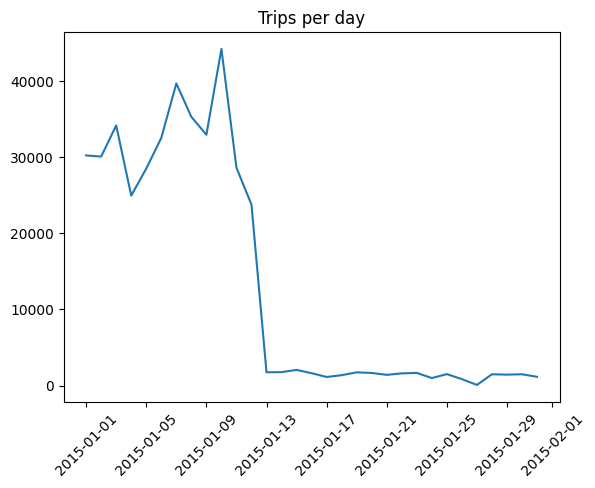

In [14]:
pdf = clean_df.groupBy("pickup_date").agg(_count("*").alias("trips")).orderBy("pickup_date").toPandas()
import matplotlib.pyplot as plt
plt.plot(pdf['pickup_date'], pdf['trips'])
plt.title("Trips per day")
plt.xticks(rotation=45)
plt.show()

## Save final aggregated artifacts + metadata

Dataset summary (num_trips, avg trip_distance, avg fare).

In [17]:
from pyspark.sql.functions import avg, min as _min, max as _max, count as _count, round

summary = clean_df.agg(
    _count("*").alias("num_trips"),
    round(avg("trip_distance"), 2).alias("avg_trip_distance"),
    round(avg("fare_amount"), 2).alias("avg_fare_amount"),
    _min("tpep_pickup_datetime_ts").alias("min_pickup_ts"),
    _max("tpep_dropoff_datetime_ts").alias("max_dropoff_ts")
)

# convert to pandas (it's a single-row dataframe — safe)
summary_pd = summary.toPandas()
summary_pd.to_csv("data/output/dataset_summary.csv", index=False)


## Results & key takeaways

Cleaned dataset size: 411,746 trips (after filters). Good sample for modeling/analytics.

Performance: partitioned Parquet + caching + broadcast join demonstrates common big data optimizations. Partition pruning returned 28k rows for a single date in ~4s — acceptable for local/dev.

Operational insight: driver_mod 8 consistently ranks #1 in revenue across many days — suggests hotspot, high-utilization driver cluster or a data artifact to investigate.

Data quality: many tip_pct values are zero — either cash payments or missing values; further investigate on payment types and tips distribution.